In [64]:
# Imports

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
import os
import shutil
import gpt
from PIL import Image
import cv2
import threading

In [ ]:
# Open Image

# Read image
IMAGE_PATH = "./diary.png"

image = Image.open(IMAGE_PATH).convert('RGB')

In [65]:
# Process Image for easier reading

# Convert PIL Image to OpenCV format
img = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Reduce noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Inprove Contrast
_, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Median blur to remove remaining spots
denoised = cv2.medianBlur(thresh, 3)

# More smoothing
denoised = cv2.GaussianBlur(denoised, (3, 3), 0)

# Convert back to RGB (but still grayscale)
denoised_3channel = cv2.cvtColor(denoised, cv2.COLOR_GRAY2BGR)
denoised_rgb = cv2.cvtColor(denoised_3channel, cv2.COLOR_BGR2RGB)

# Convert to PIL Image and then to numpy array
processed_pil = Image.fromarray(denoised_rgb)
img_arr = np.array(processed_pil, dtype=np.uint32)
original_img_arr = np.array(processed_pil, dtype=np.uint8)

In [66]:
# Set each row to avg color

for row in img_arr:
    R = 0
    G = 0
    B = 0
    for pixel in row:
        R = R + pixel[0]
        G = G + pixel[1]
        B = B + pixel[2]
    
    #Set every pixel to its average r g and b value
    avg_R = R/len(row)
    avg_G = G/len(row)
    avg_B = B/len(row)
    
    avg = (avg_R+avg_B+avg_G)/3
    
    for pixel in row:
        pixel[0] = avg
        pixel[1] = avg
        pixel[2] = avg

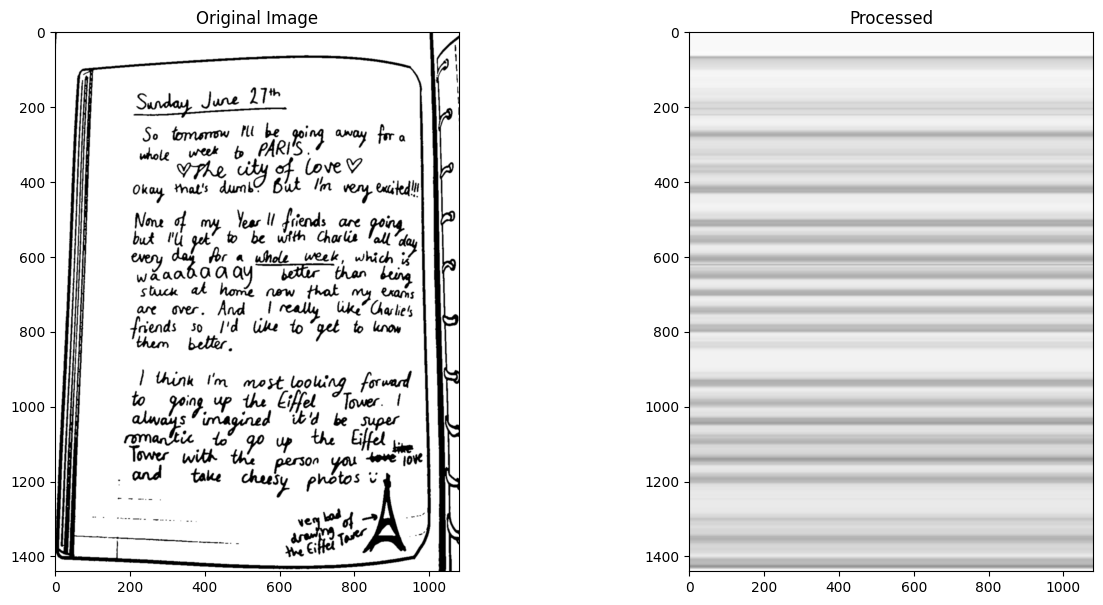

In [67]:
#Show the processed Image

# Convert the processed array back to uint8 for pillow compatibility
formatted_img_arr = np.clip(img_arr, 0, 255).astype(np.uint8)

result_img = Image.fromarray(formatted_img_arr)

plt.figure(figsize=(15, 7))  # Adjust figure size as needed

#Show Images
plt.subplot(1, 2, 1)  # (rows, columns, index)
plt.imshow(np.array(processed_pil))
#plt.axis('off')
plt.title("Original Image")

plt.subplot(1, 2, 2)  # (rows, columns, index)
plt.imshow(np.array(result_img))
#plt.axis('off')
plt.title("Processed")

plt.show()

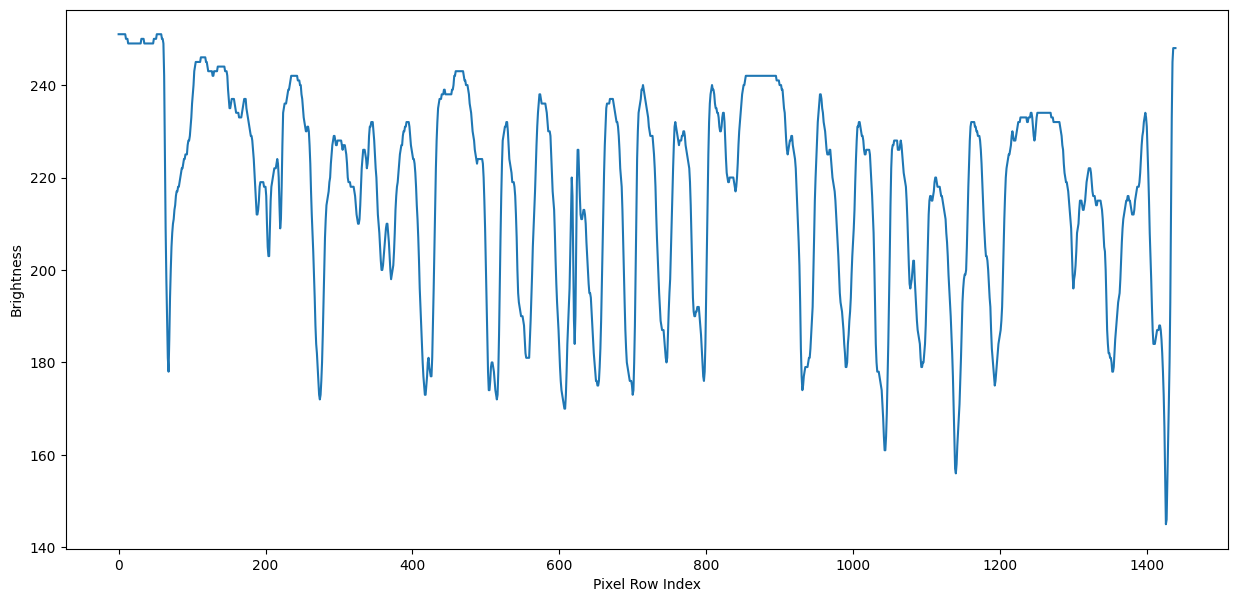

In [68]:
#Display avg brightness 

brightness = []

for row in img_arr:
    brightness.append(row[0][0])

plt.figure(figsize=(15, 7))
plt.plot(brightness)
plt.xlabel("Pixel Row Index")
plt.ylabel("Brightness")
plt.show()

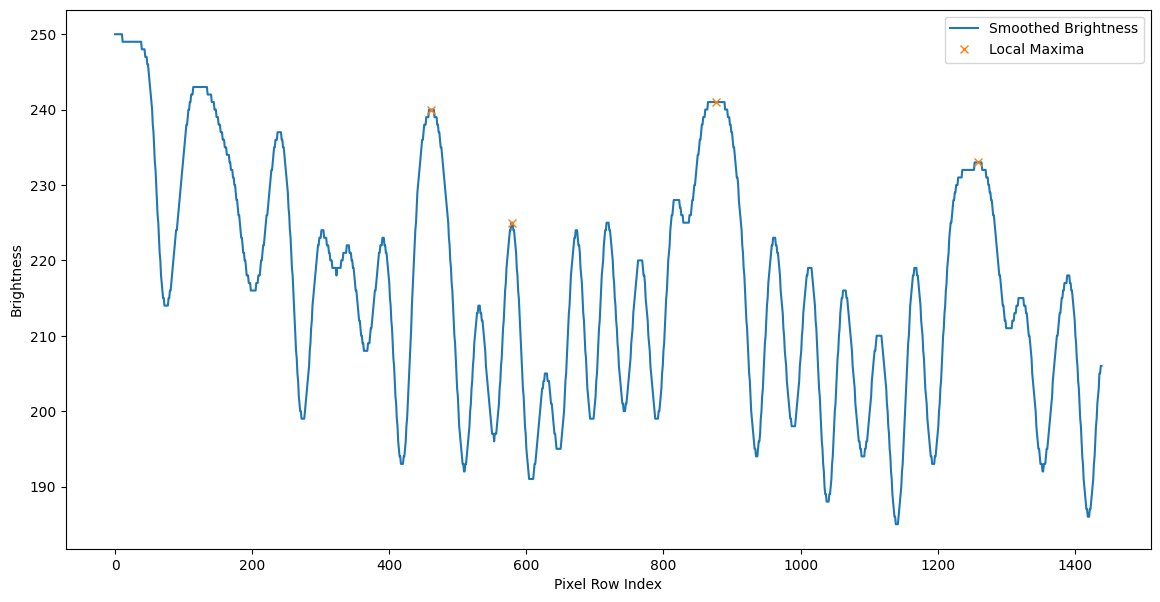

In [69]:
#Find where to split image

# Original data processing
brightness_np = np.array(brightness)
smoothed_data = gaussian_filter1d(brightness_np, sigma=10)

# More selective peak detection
peaks, _ = find_peaks(smoothed_data, 
    distance=100,          # Minimum distance between peaks
    height=None,         # Minimum height for peak to be considered
    prominence=32,       # Minimum prominence (height relative to neighboring valleys)
    width=None,         # Minimum width of peaks
    threshold=None,      # Minimum height difference with neighboring points
)

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(smoothed_data, label="Smoothed Brightness")
plt.plot(peaks, smoothed_data[peaks], "x", label="Local Maxima")
plt.xlabel("Pixel Row Index")
plt.ylabel("Brightness")
plt.legend()
plt.show()

In [70]:
# Add lines to visualize splits

lined_img_arr = original_img_arr.copy()

# Make a line wherever a split will be made

for i, row in enumerate(img_arr):
    if i in peaks:
        for pixel in row:
            pixel[0] = 0
            pixel[1] = 0
            pixel[2] = 255

for i, row in enumerate(lined_img_arr):
    if i in peaks:
        for pixel in row:
            pixel[0] = 0
            pixel[1] = 0
            pixel[2] = 255
            

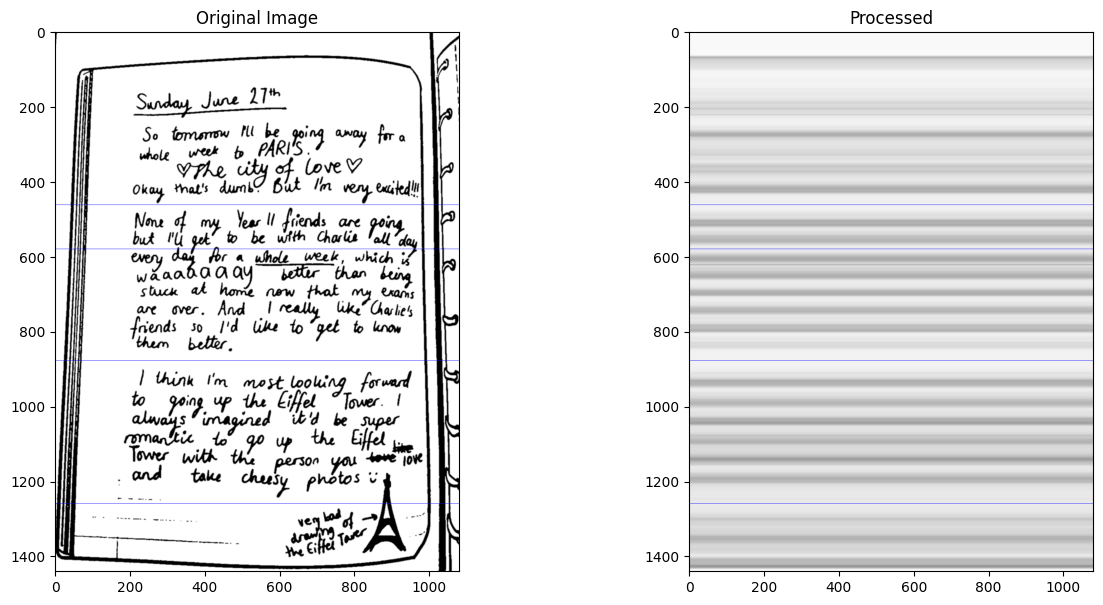

In [71]:
# Display where to split

# Convert the processed array back to uint8 for pillow compatibility
formatted_img_arr = np.clip(img_arr, 0, 255).astype(np.uint8)

result_img = Image.fromarray(formatted_img_arr)
tweaked_img = Image.fromarray(lined_img_arr)

plt.figure(figsize=(15, 7))

#Show Images
plt.subplot(1, 2, 1)  # (rows, columns, index)
plt.imshow(np.array(tweaked_img))
#plt.axis('off')
plt.title("Original Image")

plt.subplot(1, 2, 2)  # (rows, columns, index)
plt.imshow(np.array(result_img))
#plt.axis('off')
plt.title("Processed")

plt.show()

In [72]:
# Split the image into smaller Images

split_images = []
image_build = []

for i, row in enumerate(original_img_arr):
    image_build.append(row)
    
    # If the image should be split on this row
    if i in peaks:
        split_images.append(np.array(image_build))  # Convert image_build to a numpy array before appending
        image_build = []  # Reset the mini image
#Make sure to add the last one
split_images.append(np.array(image_build))

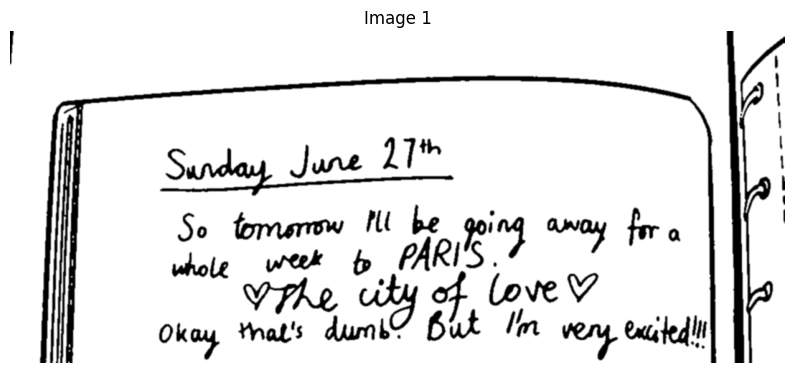

[T1-W1] S u n d a y  95%  
[T1-W2] J u n e  95%  
[T1-W3] 2 7 t h  92%

[B-L1-W1] S o  95%  
[B-L1-W2] t o m o r r o w  92%  
[B-L1-W3] I ' l l  90%  
[B-L1-W4] b e  95%  
[B-L1-W5] g o i n g  95%  
[B-L1-W6] a w a y  95%  
[B-L1-W7] f o r  95%  
[B-L1-W8] a  95%

[B-L2-W1] w h o l e  95%  
[B-L2-W2] w e e k  95%  
[B-L2-W3] t o  95%  
[B-L2-W4] P A R I S .  90%

[B-L3-W1] ♥  100%  
[B-L3-W2] T h e  95%  
[B-L3-W3] c i t y  95%  
[B-L3-W4] o f  95%  
[B-L3-W5] l o v e  95%  
[B-L3-W6] ♥  100%

[B-L4-W1] O k a y  90%  
[B-L4-W2] t h a t ' s  92%  
[B-L4-W3] d u m b .  90%  
[B-L4-W4] B u t  95%  
[B-L4-W5] I ' m  95%  
[B-L4-W6] v e r y  95%  
[B-L4-W7] e x c i t e d ! ! !  92%


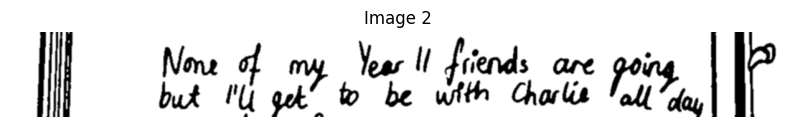

[B-L1-W1] N o n e  92%  
[B-L1-W2] o f  90%  
[B-L1-W3] m y  89%  
[B-L1-W4] Y e a r  88%  
[B-L1-W5] 1 1  87%  
[B-L1-W6] f r i e n d s  90%  
[B-L1-W7] a r e  91%  
[B-L1-W8] g o i n g  90%  
[B-L1-W9] b u t  88%  
[B-L1-W10] I ' l l  89%  
[B-L1-W11] g e t  90%  
[B-L1-W12] t o  92%  
[B-L1-W13] b e  90%  
[B-L1-W14] w i t h  91%  
[B-L1-W15] C h a r l i e  93%  
[B-L1-W16] a l l  90%  
[B-L1-W17] d a y  91%  


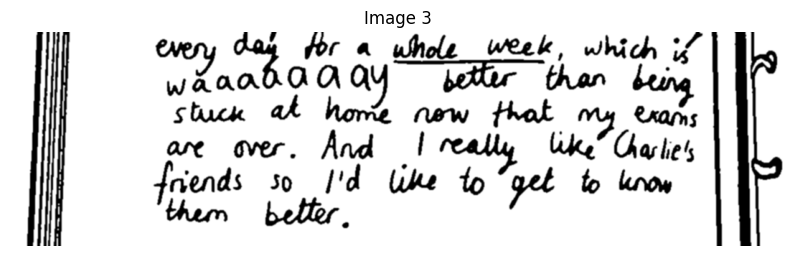

[B-L1-W1] e v e r y  95%  
[B-L1-W2] d a y  96%  
[B-L1-W3] f o r  94%  
[B-L1-W4] a  97%  
[B-L1-W5] w h o l e  88%  
[B-L1-W6] w e e k  92%  
[B-L1-W7] ,  98%  
[B-L1-W8] w h i c h  90%  
[B-L1-W9] i s  93%  
[B-L2-W1] w a a a a a a a y  94%  
[B-L3-W1] b e t t e r  92%  
[B-L3-W2] t h a n  91%  
[B-L3-W3] b e i n g  90%  
[B-L4-W1] s t u c k  88%  
[B-L4-W2] a t  95%  
[B-L4-W3] h o m e  96%  
[B-L4-W4] n o w  94%  
[B-L4-W5] t h a t  92%  
[B-L4-W6] m y  97%  
[B-L4-W7] e x a m s  90%  
[B-L5-W1] a r e  95%  
[B-L5-W2] o v e r  96%  
[B-L5-W3] .  98%  
[B-L6-W1] A n d  95%  
[B-L6-W2] I  97%  
[B-L6-W3] r e a l l y  91%  
[B-L6-W4] l i k e  94%  
[B-L6-W5] C h a r l i e ' s  88%  
[B-L7-W1] f r i e n d s  92%  
[B-L7-W2] s o  95%  
[B-L7-W3] I ' d  94%  
[B-L7-W4] l i k e  90%  
[B-L7-W5] t o  93%  
[B-L7-W6] g e t  96%  
[B-L7-W7] t o  95%  
[B-L7-W8] k n o w  92%  
[B-L8-W1] t h e m  93%  
[B-L8-W2] b e t t e r  91%  
[B-L8-W3] .  98%


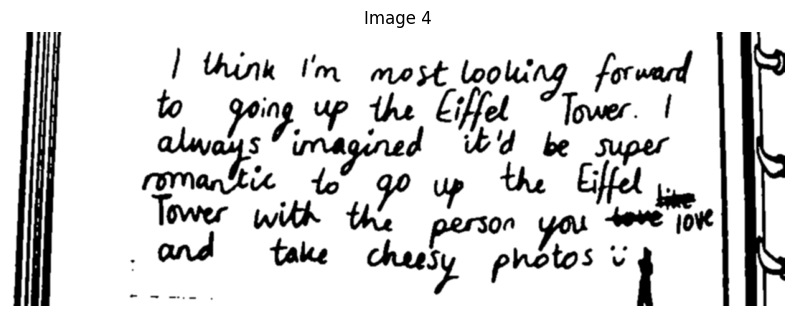

[B-L1-W1] I 95%  
[B-L1-W2] t h i n k 92%  
[B-L1-W3] I ' m 90%  
[B-L1-W4] m o s t 93%  
[B-L1-W5] l o o k i n g 92%  
[B-L1-W6] f o r w a r d 91%  
[B-L1-W7] t o 95%  
[B-L1-W8] g o i n g 92%  
[B-L1-W9] u p 94%  
[B-L1-W10] t h e 93%  
[B-L1-W11] E i f f e l 95%  
[B-L1-W12] T o w e r . 95%  
[B-L2-W1] I 95%  
[B-L2-W2] a l w a y s 93%  
[B-L2-W3] i m a g i n e d 90%  
[B-L2-W4] i t ' d 88%  
[B-L2-W5] b e 95%  
[B-L2-W6] s u p e r 92%  
[B-L2-W7] r o m a n t i c 91%  
[B-L2-W8] t o 95%  
[B-L2-W9] g o 95%  
[B-L2-W10] u p 94%  
[B-L2-W11] t h e 93%  
[B-L2-W12] E i f f e l 95%  
[B-L3-W1] T o w e r 95%  
[B-L3-W2] w i t h 94%  
[B-L3-W3] t h e 93%  
[B-L3-W4] p e r s o n 92%  
[B-L3-W5] y o u 94%  
[B-L3-W6] l o v e 92%  
[B-L3-W7] a n d 94%  
[B-L3-W8] t a k e 91%  
[B-L3-W9] c h e e s y 90%  
[B-L3-W10] p h o t o s 92%  
[B-L3-W11] :) 95%


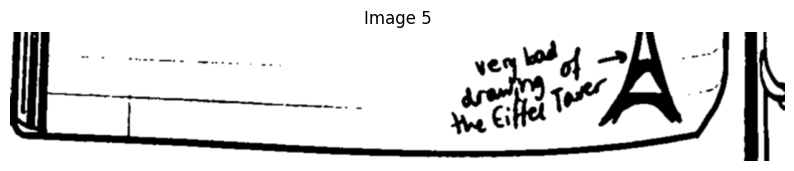

[B-L1-W1] v e r y  92%
[B-L1-W2] b a d  90%
[B-L1-W3] o f  85%
[B-L1-W4] d r a w i n g  88%
[B-L1-W5] t h e  90%
[B-L1-W6] E i f f e l  93%
[B-L1-W7] T o w e r  95%


In [73]:
# Save and print all results

# Directory to save the split images
output_dir = "split_images"

# Clear the directory if it exists
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)  # Remove the directory and all its contents
os.makedirs(output_dir, exist_ok=True)  # Recreate the empty directory

responses = []
threads = []
num_threads = 5 

def readImage(responses, i, pic):
    converted_img = Image.fromarray(pic)
    
    # Save the image
    image_path = os.path.join(output_dir, f"image_{i+1}.png")
    converted_img.save(image_path)
    
    #Get chatGPT translation
    responses[i] = gpt.run_chatgpt(image_path)

responses = [None] * len(split_images)  # Initialize responses with size so it is thread safe
threads = []

# Start threads
for i, pic in enumerate(split_images):
    t = threading.Thread(target=readImage, args=(responses, i, pic))
    threads.append(t)
    t.start()

# Wait for all threads to finish
for t in threads:
    t.join()

# Display each image and its response in the original order
for i, pic in enumerate(split_images):
    plt.figure(figsize=(10, 10))
    plt.imshow(pic)
    plt.axis('off')
    plt.title(f"Image {i+1}")
    plt.show()
    print(responses[i])